In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
from sklearn.model_selection import train_test_split
iris = load_iris()

In [2]:
X = iris['data']
y = iris['target']
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [3]:
import numpy as np
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [4]:
left_nodes = clf.tree_.children_left[clf.tree_.children_left>0]
right_nodes = clf.tree_.children_right[clf.tree_.children_right>0]

In [5]:
left_nodes

array([ 1,  3,  4,  5,  8, 10, 13, 14])

In [6]:
right_nodes

array([ 2, 12,  7,  6,  9, 11, 16, 15])

In [7]:
clf.tree_.node_count

17

In [8]:
## Extract path
node_indicator = clf.decision_path(X)

In [9]:
path_list = []
for i, j in enumerate(X):
    path_list.append(node_indicator.indices[node_indicator.indptr[i]:node_indicator.indptr[i+1]])

In [10]:
path_list[0]

array([0, 1], dtype=int32)

In [11]:
## Convert path to strings
path_column = np.array([])
for i, j in enumerate(X):
    path_as_string = []
    for node in path_list[i]:
        if node == 0:
            path_as_string.append('S')
        elif node in left_nodes:
            path_as_string.append('L')
        elif node in right_nodes:
            path_as_string.append('R')
            
    path_as_string.append('T')
    path_as_string = ''.join(path_as_string)
    path_column = np.append(path_column, path_as_string)

# X[:,:-1] = path_column.reshape(-1,1)
            

In [13]:
X = np.hstack((X, path_column.reshape(-1,1)))

In [15]:
X.shape

(150, 5)

In [74]:
path_list[149]

array([ 0,  2, 12, 16], dtype=int32)

### RNN implementation

---

## Trial notes(please ignore)

In [1]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

estimator = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
estimator.fit(X_train, y_train)

# The decision estimator has an attribute called tree_  which stores the entire
# tree structure and allows access to low level attributes. The binary tree
# tree_ is represented as a number of parallel arrays. The i-th element of each
# array holds information about the node `i`. Node 0 is the tree's root. NOTE:
# Some of the arrays only apply to either leaves or split nodes, resp. In this
# case the values of nodes of the other type are arbitrary!
#
# Among those arrays, we have:
#   - left_child, id of the left child of the node
#   - right_child, id of the right child of the node
#   - feature, feature used for splitting the node
#   - threshold, threshold value at the node
#

# Using those arrays, we can parse the tree structure:

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

In [2]:
# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

The binary tree structure has 5 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 3] <= 0.800000011920929 else to node 2.
	node=1 leaf node.
	node=2 test node: go to node 3 if X[:, 2] <= 4.950000047683716 else to node 4.
		node=3 leaf node.
		node=4 leaf node.



In [12]:
# First let's retrieve the decision path of each sample. The decision_path
# method allows to retrieve the node indicator functions. A non zero element of
# indicator matrix at the position (i, j) indicates that the sample i goes
# through the node j.

node_indicator = estimator.decision_path(X_test)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = estimator.apply(X_test)

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X_test[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             X_test[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

# For a group of samples, we have the following common node.
sample_ids = [0, 1]
common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))

common_node_id = np.arange(n_nodes)[common_nodes]

print("\nThe following samples %s share the node %s in the tree"
      % (sample_ids, common_node_id))
print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))

Rules used to predict sample 0: 
decision id node 0 : (X_test[0, 3] (= 2.4) > 0.800000011920929)
decision id node 2 : (X_test[0, 2] (= 5.1) > 4.950000047683716)

The following samples [0, 1] share the node [0 2] in the tree
It is 40.0 % of all nodes.


In [68]:
np.zeros(shape=n_nodes, dtype=np.int64)

array([0, 0, 0, 0, 0])

In [70]:
np.zeros(shape=n_nodes, dtype=bool)

array([False, False, False, False, False])

In [3]:
node_depth

array([0, 1, 1, 2, 2])

In [4]:
is_leaves

array([False,  True, False,  True,  True])

In [5]:
children_left

array([ 1, -1,  3, -1, -1])

In [6]:
children_right

array([ 2, -1,  4, -1, -1])

In [8]:
!pip install pydotplus

     |████████████████████████████████| 286kB 746kB/s eta 0:00:01
  Stored in directory: /home/shakkeel/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


In [9]:
from IPython.display import Image  
from sklearn import tree
import pydotplus

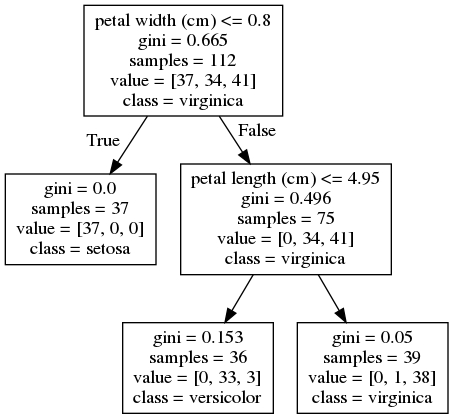

In [11]:
# Create DOT data
dot_data = tree.export_graphviz(estimator, out_file=None, 
                                feature_names=iris.feature_names,  
                                class_names=iris.target_names)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [41]:
node_indicator

<38x5 sparse matrix of type '<class 'numpy.int64'>'
	with 101 stored elements in Compressed Sparse Row format>

In [35]:
leave_id

array([4, 3, 1, 4, 1, 4, 1, 3, 3, 3, 4, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3,
       1, 1, 3, 1, 1, 3, 3, 1, 4, 3, 1, 3, 4, 3, 1, 4])

In [48]:
## Collecting path - loop through this
node_indicator.indices[node_indicator.indptr[20]:node_indicator.indptr[21]]

array([0, 2, 3], dtype=int32)

In [46]:
## Converting path to strings
left_nodes = children_left[children_left>0]
right_nodes = children_right[children_right>0]

In [49]:
left_nodes

array([1, 3])

In [50]:
right_nodes

array([2, 4])

In [34]:
node_indicator.indices[node_indicator.indptr[31]:
                                    node_indicator.indptr[32]]

array([0, 2, 3], dtype=int32)

In [27]:
node_indicator.indptr

array([  0,   3,   6,   8,  11,  13,  16,  18,  21,  24,  27,  30,  33,
        36,  39,  42,  44,  47,  50,  52,  54,  57,  60,  62,  64,  67,
        69,  71,  74,  77,  79,  82,  85,  87,  90,  93,  96,  98, 101],
      dtype=int32)

In [36]:
feature

array([ 3, -2,  2, -2, -2])

In [37]:
threshold

array([ 0.80000001, -2.        ,  4.95000005, -2.        , -2.        ])

In [57]:
a = 's'

In [59]:
u = a.join('l')

In [60]:
u

'l'

In [76]:
test = np.array([])

np.append(test, 'start')

array(['start'], dtype='<U32')

In [77]:
np.append(test, 'end')

array(['end'], dtype='<U32')

In [91]:
test = load_iris()

In [92]:
test['data']

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3